# EE 304 - Neuromorphics: Brains in Silicon

## Transformation

- The story so far:
    - The activity of groups of neurons, $a_1,a_2,\ldots,a_N$, can *encode* variables ${\bf x}$
        - ${\bf x}$ can be an aribitrary-dimension vector
        - Each neuron has a preferred vector ${\bf e}$
        - Current going into each neuron is $J = \alpha {\bf e}^{\rm T}{\bf x} + J^{\rm bias}$
    - We can *decode* neural activity via $\hat{\bf x}=\sum a_i {\bf d}_i$
        - For spiking neurons, we filter the spikes first: $\hat{\bf x}=\sum (a_i(t)*h(t)) {\bf d}_i$
        - To compute ${\bf d}_i$, we choose some ${\bf x}$ values
        - Then, we sample $a_i({\bf x})$ at these points
        - Finally, we solve for the optimal ${\bf d}_i$ (assuming some amount of noise)
    
- So far we've just talked about neural activity in a single population
- What about connections from one populaiton to another?

<img src="files/lecture4/communication1.png">


### Connecting neurons

- Up till now, we've always had the current going into a neuron be something we computed from $x$
    - $J = \alpha {\bf e}^{\rm T}{\bf x} + J^{\rm bias}$
- This will continue to be how we handle inputs
    - Sensory neurons, for example
    - Or whatever's coming a part of the brain that we're not modelling (yet)
- But what about other groups of neurons?
    - How do they end up getting the amount of input current that we're injecting
    - That is, $J = \alpha {\bf e}^{\rm T}{\bf x} + J^{\rm bias}$ ?
- Their input current comes from:
    - Inputs from other neurons that are connected to them
    - Delivered through weighted synaptic connections

### A communication channel

- Let's say we have two groups of neurons
    - One group represents $x$
    - The other represents $y$
- How do we pass the value of $x$ from the first group to the other?
    - That is, set $y=\hat{x}$
- We can do this in four steps:
    - First, drive the first group with the input $x$
    - Second, decode their activity, $a$, to get $\hat{x}$
    - Third, use $y=\hat{x}$ to drive the second group
    - Fourth, decode their activity, $b$, to get $\hat{y}$
- Let's start by first constructing the two populations
    - Stimulate them both directly and decode to compare

In [1]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
%matplotlib inline

from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.solvers import LstsqL2

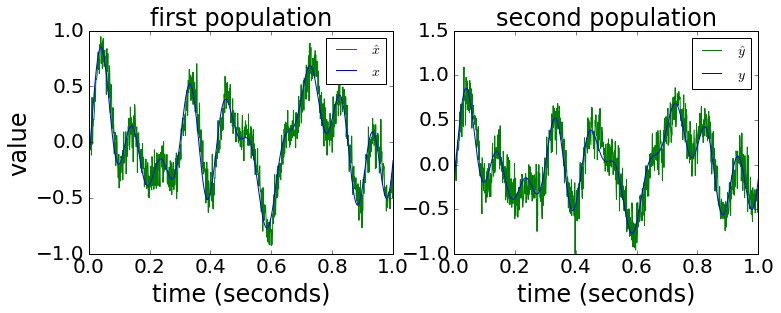

In [5]:
T = 1.0
max_freq = 10

noise = WhiteSignal(period=T, high=max_freq, rms=0.5, seed=3)

model = nengo.Network('Communication Channel', seed=3)

with model:
    stim = nengo.Node(noise)
    ensA = nengo.Ensemble(20, dimensions=1, neuron_type=nengo.LIFRate())
    ensB = nengo.Ensemble(19, dimensions=1, neuron_type=nengo.LIFRate())
    temp = nengo.Ensemble(1, dimensions=1, neuron_type=nengo.LIFRate())
    
    nengo.Connection(stim, ensA)
    stim_B = nengo.Connection(stim, ensB)
    
    connectionA = nengo.Connection(ensA, temp) #This is just to generate the decoders
    connectionB = nengo.Connection(ensB, temp) #This is just to generate the decoders
     
    stim_p = nengo.Probe(stim)
    a_rates = nengo.Probe(ensA.neurons, 'rates')
    b_rates = nengo.Probe(ensB.neurons, 'rates')
   
sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

x = sim.data[stim_p]

d_i = sim.data[connectionA].weights.T
A_i = sim.data[a_rates]

d_j = sim.data[connectionB].weights.T
A_j = sim.data[b_rates]

#Add noise
A_i = A_i + np.random.normal(scale=0.2*np.max(A_i), size=A_i.shape)
A_j = A_j + np.random.normal(scale=0.2*np.max(A_j), size=A_j.shape)

xhat_i = np.dot(A_i, d_i)
yhat_j = np.dot(A_j, d_j)

t = sim.trange()
figure(figsize=(12,4))
subplot(1,2,1)
plot(t, xhat_i, 'g', label='$\hat{x}$')
plot(t, x, 'b', label='$x$')
legend(fontsize=14)
xlabel('time (seconds)')
ylabel('value')
title('first population')

subplot(1,2,2)
plot(t, yhat_j, 'g', label='$\hat{y}$')
plot(t, x, 'b', label='$y$')
legend(fontsize=14)
xlabel('time (seconds)')
title('second population');

- So everything works fine if we drive each population with the same $x$, let's switch to $\hat{x}$ in the middle

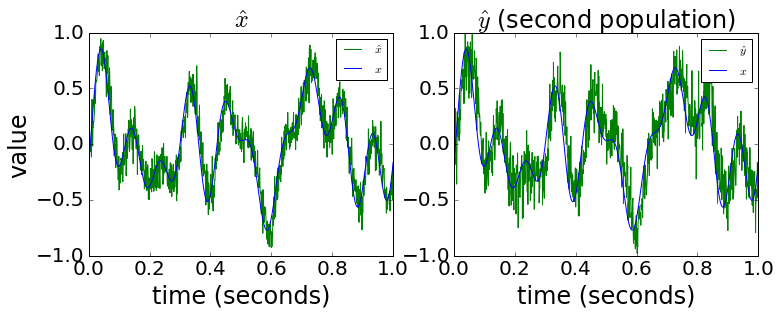

In [6]:
#Have to run previous cells first
model.connections.remove(stim_B)
del stim_B

def xhat_fcn(t):
    idx = int(t/sim.dt)
    if idx>=1000: idx=999
    return xhat_i[idx]

#This resets the white noise process
# stim.output.func_closure[0].cell_contents.keywords['t'] = np.array([0])

with model:
    xhat = nengo.Node(xhat_fcn)
    
    nengo.Connection(xhat, ensB)
    
    xhat_p = nengo.Probe(xhat)
    
sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

d_j = sim.data[connectionB].weights.T
A_j = sim.data[b_rates]

A_j = A_j + np.random.normal(scale=0.2*np.max(A_j), size=A_j.shape)

yhat_j = np.dot(A_j, d_j)

t = sim.trange()
figure(figsize=(12,4))
subplot(1,2,1)
plot(t, xhat_i, 'g', label='$\hat{x}$')
plot(t, x, 'b', label='$x$')
legend()
xlabel('time (seconds)')
ylabel('value')
title('$\hat{x}$')
ylim(-1,1)

subplot(1,2,2)
plot(t, yhat_j, 'g', label='$\hat{y}$')
plot(t, x, 'b', label='$x$')
legend()
xlabel('time (seconds)')
title('$\hat{y}$ (second population)')
ylim(-1,1);

- Looks pretty much the same! (just delayed, maybe)
- So now we've passed one value to the other
- But its implausible:
    - The brain doesn't decode and then re-encode
    - Can we skip those steps?  Or combine them?

### A shortcut

- Let's write down what we've done:
    - Encode into $a$: $a_i = G_i(\alpha_i e_i x + J^{\rm bias}_i)$
    - Decode from $a$: $\hat{x} = \sum_i a_i d_i$
    - Set $y = \hat{x}$
    - Encode into $b$: $b_j = G_j(\alpha_j e_j y + J^{bias}_j)$
    - Decode from $b$: $\hat{y} = \sum_j b_j d_j$

- Now let's just do the substitutions:
    - Substituting $y = \hat{x} = \sum_i a_i d_i$ into $b_j$:
        - $b_j = G_j(\alpha_j e_j \sum_i a_i d_i + J^{\rm bias}_j)$
        - $b_j = G_j(\sum_i \alpha_j e_j d_i a_i  + J^{\rm bias}_j)$
        - $b_j = G_j(\sum_i \omega_{ij}a_i + J^{\rm bias}_j)$
            - where $\omega_{ij} = \alpha_j e_jd_i$ 
- In other words, the entire weight matrix is the outer product of 
    - the first population's decoders 
    - and the second population's encoders 

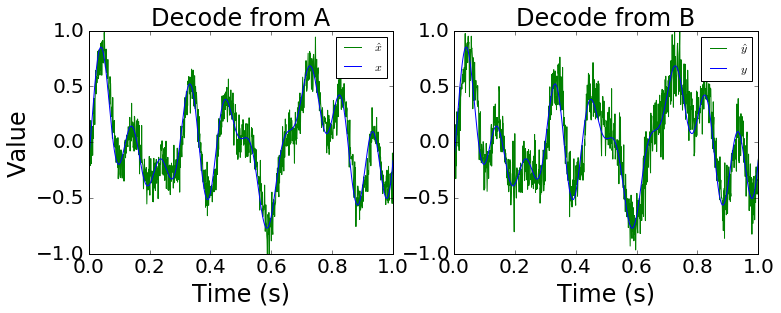

In [4]:
#Have to run previous cells first
n = nengo.neurons.LIFRate()

alpha_j = sim.data[ensB].gain
bias_j = sim.data[ensB].bias
encoders_j = sim.data[ensB].encoders.T

weights = np.outer(alpha_j*encoders_j, d_i)

J_j = np.dot(weights, sim.data[a_rates].T).T + bias_j

A_j = n.rates(J_j, gain=1, bias=0) #Gain and bias already in the previous line

A_j = A_j + np.random.normal(scale=0.2*np.max(A_j), size=A_j.shape)

xhat_j = np.dot(A_j, d_j)

figure(figsize=(12,4))
subplot(1,2,1)
plot(t, xhat_i, 'g', label='$\hat{x}$')
plot(t, x, 'b', label='$x$')
legend()
xlabel('Time (s)')
ylabel('Value')
title('Decode from A')
ylim(-1,1)

subplot(1,2,2)
plot(t, xhat_j, 'g', label='$\hat{y}$')
plot(t, x, 'b', label='$y$')
legend()
xlabel('Time (s)')
title('Decode from B');
ylim(-1,1);

- In fact, instead of computing $\omega_{ij}$ at all, it is (usually) more efficient to just do the encoding/decoding
    - Saves a lot of memory space, since you don't have to store a giant weight matrix
    - Also, you have NxM multiplies for weights, but only do ~N+M multiplies for encode/decode
    

In [5]:
J_j = np.outer(np.dot(A_i, d_i), alpha_j*encoders_j)+bias_j

- This means we get the exact same effect as having a weight matrix $\omega_{ij}$ if we just take the decoded value from one population and feed that into the next population using the normal encoding method
    - These are numerically identical processes, since $\omega_{ij} = \alpha_j e_jd_i$

### Spiking neurons

- The same approach works for spiking neurons
    - Do exactly the same as before
    - The $a_i(t)$ values are spikes, and we convolve with $h(t)$
    

## Other transformations

- So this lets us take an $x$ value and feed it into another population
    - Passing information from one group of neurons to the next
    - We call this a *Communication Channel* as you're just sending the information
- What about transforming that information in some way?
    - Instead of $y=x$, can we do $y=f(x)$?
- Let's try $y=2x$ to start
- We already have a decoder for $\hat{x}$, so how do we get a decoder for $\hat{2x}$?
    - Two ways
        - Either use $2x$ when computing $\Upsilon$
        - Or just multiply your *representational* decoder by $2$

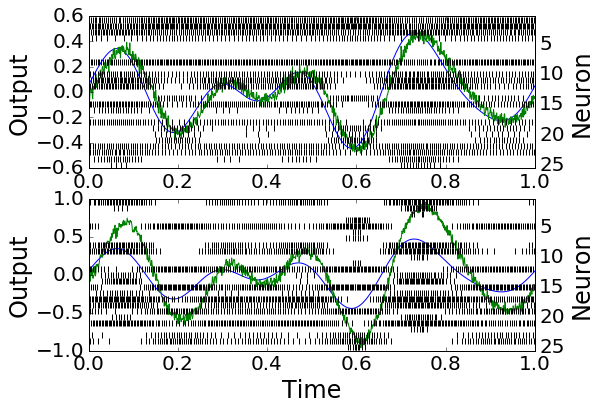

In [7]:
import nengo
from nengo.processes import WhiteSignal
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5
N = 25

in_stim = WhiteSignal(period=T, high=max_freq, rms=0.3, seed=3)

model = nengo.Network()
with model:
    stim = nengo.Node(in_stim)
    ensA = nengo.Ensemble(N, dimensions=1)
    ensB = nengo.Ensemble(N, dimensions=1)
    
    nengo.Connection(stim, ensA)
    nengo.Connection(ensA, ensB, transform=2) #function=lambda x: 2*x)
    
    stim_p = nengo.Probe(stim)
    ensA_p = nengo.Probe(ensA, synapse=.01)
    ensB_p = nengo.Probe(ensB, synapse=.01)
    ensA_spikes_p = nengo.Probe(ensA.neurons, 'spikes')
    ensB_spikes_p = nengo.Probe(ensB.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

t = sim.trange()
figure(figsize=(8, 6))
subplot(2,1,1)
ax = gca()
plot(t, sim.data[stim_p],'b')
plot(t, sim.data[ensA_p],'g')
ylabel("Output")
rasterplot(t, sim.data[ensA_spikes_p], ax=ax.twinx(), colors=['k' for i in xrange(N)])
ylabel("Neuron")

subplot(2,1,2)
ax = gca()
plot(t, sim.data[stim_p],'b')
plot(t, sim.data[ensB_p],'g')
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[ensB_spikes_p], ax=ax.twinx(), colors=['k' for i in xrange(N)])
ylabel("Neuron");

- What about a nonlinear function?
    - $y = x^2$
    
    

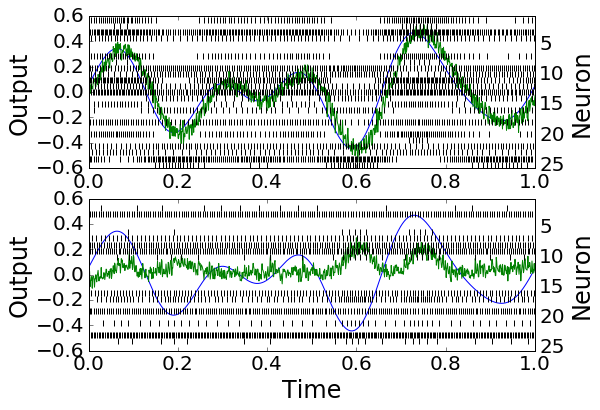

In [8]:
import nengo
from nengo.processes import WhiteSignal
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5
N = 25

in_stim = WhiteSignal(period=T, high=max_freq, rms=0.3, seed=3)

model = nengo.Network()

with model:
    stim = nengo.Node(in_stim)
    ensA = nengo.Ensemble(N, dimensions=1)
    ensB = nengo.Ensemble(N, dimensions=1)
    
    nengo.Connection(stim, ensA)
    nengo.Connection(ensA, ensB, function=lambda x: x**2)
    
    stim_p = nengo.Probe(stim)
    ensA_p = nengo.Probe(ensA, synapse=.01)
    ensB_p = nengo.Probe(ensB, synapse=.01)
    ensA_spikes_p = nengo.Probe(ensA.neurons, 'spikes')
    ensB_spikes_p = nengo.Probe(ensB.neurons, 'spikes')
   
sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

t = sim.trange()
figure(figsize=(8, 6))
subplot(2,1,1)
ax = gca()
plot(t, sim.data[stim_p],'b')
plot(t, sim.data[ensA_p],'g')
ylabel("Output")
rasterplot(t, sim.data[ensA_spikes_p], ax=ax.twinx(), colors=['k' for i in xrange(N)])
ylabel("Neuron")

subplot(2,1,2)
ax = gca()
plot(t, sim.data[stim_p],'b')
plot(t, sim.data[ensB_p],'g')
ylabel("Output")
xlabel("Time");
rasterplot(t, sim.data[ensB_spikes_p], ax=ax.twinx(), colors=['k' for i in xrange(N)])
ylabel("Neuron");

- When you set the connection *function* in Nengo, it solves the same decoding equation as before, but for a function.
- In equations:
    - $ {\bf d}^{\bf f} = {\bf \Gamma}^{-1}{\bf \Upsilon}^{\bf f} $
    - $ {\bf \Upsilon}^{\bf f} = {\bf A}^{\rm T}{\bf f}$
    - $ {\bf \Gamma} = {\bf A}^{\rm T}{\bf A}$
    - $ \hat{\bf f} ={\bf A}{\bf d}^{\bf f}$

- In code:

<div style="display:block; border: 1px solid black; padding: 15px;margin: 10px">
<code>f_x = my_function(x)
gamma=np.dot(A.T,A)
upsilon_f=np.dot(A.T,f_x)
d_f = np.dot(np.linalg.pinv(gamma),upsilon)
fhat = np.dot(A, d_f)
</code>
</div>

- We call standard ${\bf d}$ *representational decoders*
- We call ${\bf d}^{\bf f}$ *transformational decoders* (or "decoders for $f(x)$")

%% Got up to here

### Adding

- What if we want to combine the inputs from two different populations?
    - Linear case: $z=x+y$

<img src="files/lecture4/adding1.png">


- We want the total current going into a $z$ neuron to be $J=\alpha e(x+y) + J^{\rm bias}$
- How can we achieve this?
- Again, substitute into the equation, where $z = x+y \approx \hat{x}+\hat{y}$
    - $J_k=\alpha_k e_k(\hat{x}+\hat{y}) + J_k^{\rm bias}$
    - $\hat{x} = \sum_i a_i d_i$
    - $\hat{y} = \sum_j a_j d_j$
    - $J_k=\alpha_k e_k(\sum_i a_i d_i+\sum_j a_j d_j) + J_k^{\rm bias}$
    - $J_k=\sum_i(\alpha_k e_k d_i a_i) + \sum_j(\alpha_k e_k d_j a_j) + J_k^{\rm bias}$
    - $J_k=\sum_i(\omega_{ik} a_i) + \sum_j(\omega_{jk} a_j) + J_k^{\rm bias}$
    - $\omega_{ik}=\alpha_k e_k d_i$ and $\omega_{jk}=\alpha_k e_k d_j$ 
- Putting multiple inputs into a neuron automatically gives us addition!

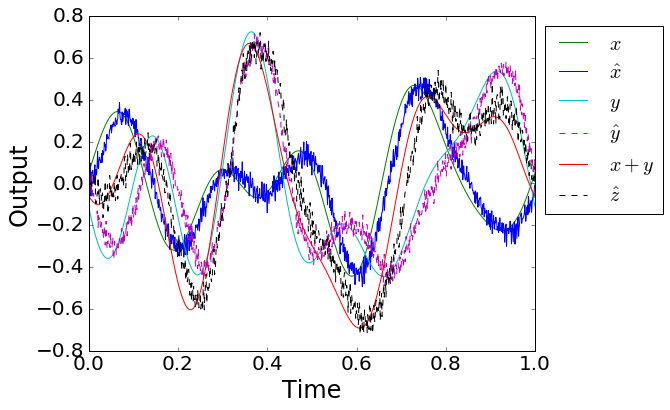

In [8]:
import nengo
from nengo.processes import WhiteSignal
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5

model = nengo.Network()

with model:
    stimA = nengo.Node(WhiteSignal(period=T, high=max_freq, rms=0.3, seed=3))
    stimB = nengo.Node(WhiteSignal(period=T, high=max_freq, rms=0.3, seed=5))
    
    ensA = nengo.Ensemble(25, dimensions=1)
    ensB = nengo.Ensemble(23, dimensions=1)
    ensC = nengo.Ensemble(24, dimensions=1)
    
    nengo.Connection(stimA, ensA)
    nengo.Connection(stimB, ensB)
    nengo.Connection(ensA, ensC)
    nengo.Connection(ensB, ensC)
    
    stimA_p = nengo.Probe(stimA)
    stimB_p = nengo.Probe(stimB)
    ensA_p = nengo.Probe(ensA, synapse=.01)
    ensB_p = nengo.Probe(ensB, synapse=.01)
    ensC_p = nengo.Probe(ensC, synapse=.01)
   
sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

figure(figsize=(8,6))
plot(t, sim.data[stimA_p],'g', label="$x$")
plot(t, sim.data[ensA_p],'b', label="$\hat{x}$")
plot(t, sim.data[stimB_p],'c', label="$y$")
plot(t, sim.data[ensB_p],'m--', label="$\hat{y}$")
plot(t, sim.data[stimB_p]+sim.data[stimA_p],'r', label="$x+y$")
plot(t, sim.data[ensC_p],'k--', label="$\hat{z}$")
legend(loc='upper left', bbox_to_anchor=(1., 1.), fontsize=20)
ylabel("Output")
xlabel("Time");

### Vectors

- Almost nothing changes

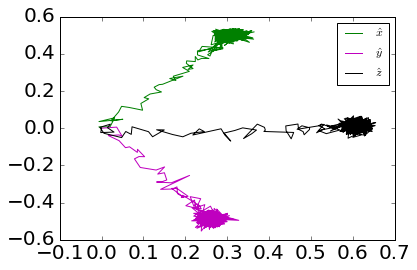

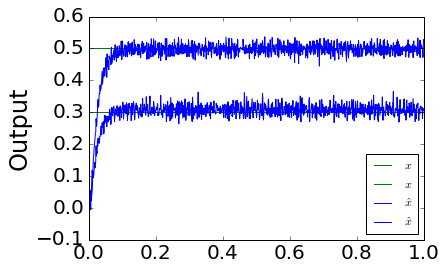

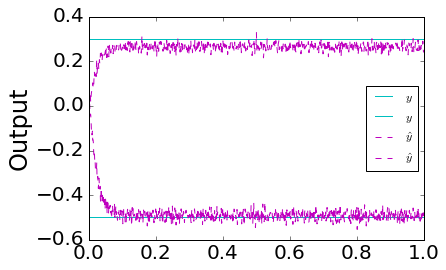

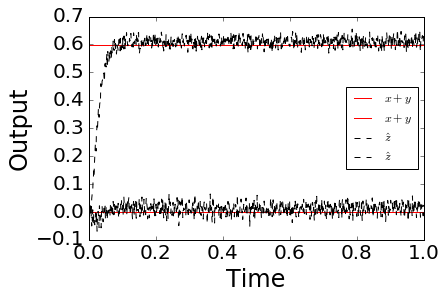

In [9]:
import nengo
from nengo.processes import WhiteSignal
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5

in_stim = WhiteSignal(period=T, high=max_freq, rms=0.3, seed=3)

model = nengo.Network()

with model:
    #stimA = nengo.Node(in_stim.f(d=2, rng=np.random.RandomState(3)))
    #stimB = nengo.Node(in_stim.f(d=2, rng=np.random.RandomState(5)))
    
    stimA = nengo.Node([.3,.5])
    stimB = nengo.Node([.3,-.5])
    
    ensA = nengo.Ensemble(55, dimensions=2)
    ensB = nengo.Ensemble(53, dimensions=2)
    ensC = nengo.Ensemble(54, dimensions=2)
    
    nengo.Connection(stimA, ensA)
    nengo.Connection(stimB, ensB)
    nengo.Connection(ensA, ensC)
    nengo.Connection(ensB, ensC)
    
    stimA_p = nengo.Probe(stimA)
    stimB_p = nengo.Probe(stimB)
    ensA_p = nengo.Probe(ensA, synapse=.02)
    ensB_p = nengo.Probe(ensB, synapse=.02)
    ensC_p = nengo.Probe(ensC, synapse=.02)
   
sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

figure()
plot(sim.data[ensA_p][:,0], sim.data[ensA_p][:,1], 'g', label="$\hat{x}$")
plot(sim.data[ensB_p][:,0], sim.data[ensB_p][:,1], 'm', label="$\hat{y}$")
plot(sim.data[ensC_p][:,0], sim.data[ensC_p][:,1], 'k', label="$\hat{z}$")
legend(loc='best')

figure()
plot(t, sim.data[stimA_p],'g', label="$x$")
plot(t, sim.data[ensA_p],'b', label="$\hat{x}$")
legend(loc='best')
ylabel("Output")

figure()
plot(t, sim.data[stimB_p],'c', label="$y$")
plot(t, sim.data[ensB_p],'m--', label="$\hat{y}$")
legend(loc='best')
ylabel("Output")

figure()
plot(t, sim.data[stimB_p]+sim.data[stimA_p],'r', label="$x+y$")
plot(t, sim.data[ensC_p],'k--', label="$\hat{z}$")
legend(loc='best')
ylabel("Output")
xlabel("Time");

### Summary

- We can use the decoders to find connection weights between groups of neurons
    - $\omega_{ij}=\alpha_j e_j d_i$
- Using connection weights is numerically identical to decoding and then encoding again
    - Which can be much more efficient to implement
- Feeding two inputs into the same population results in addition
- These shortcuts rely on two assumptions:
    - The input to a neuron is a weighted sum of its synaptic inputs
        - $J_j = \sum_i \omega_{ij}a_i $
    - The mapping from ${\bf x}$ to $J$ is of the form:
        - $J_j=\alpha_j {\bf e}_j^{\rm T}{\bf x} + J_j^{\rm bias}$
- If these assumptions don't hold, you have to do some other form of optimization    

- Given a decoder for ${\bf x}$, a decoder for any linear function of ${\bf x}$ is easily found
    - If the decoder for ${\bf x}$ is ${\bf d}_i$
    - The decoder for ${\bf M}{\bf x}$ is ${\bf M}{\bf d}_i$
- For a nonlinear function of ${\bf x}$, substitute in that function ${\bf f}({\bf x})$ when finding $\Upsilon$
- Taking all of this into account, the most general form of the weights is:
    -  $\omega_{ij} = {\bf e}_j {\bf M}{\bf d}_i^{\bf f}$

### What about nonlinear functions of more than one variable?

- What if we want to compute a nonlinear function of two inputs?
    - For example, $z=x \times y$
- We know how to compute nonlinear functions of a single vector
    - For example, ${\bf x}^{\rm T}{\bf x}$
        - Expanding this out yields a bunch of products
        - For instance, if ${\bf x}$ is 2D we get $x_1^2 + 2 x_1 x_2 + x_2^2$
- Implying that you can get the product of your two inputs by combining them into a 2D vector 

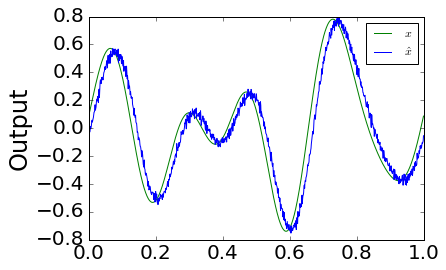

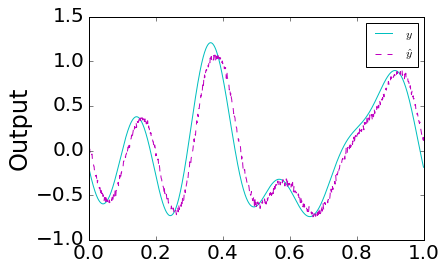

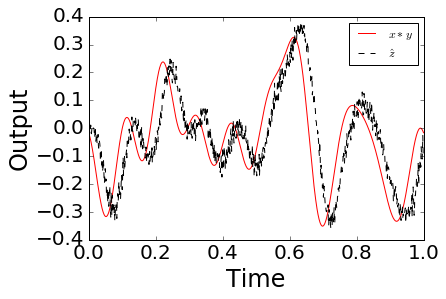

In [10]:
import nengo
from nengo.processes import WhiteSignal
from nengo.utils.matplotlib import rasterplot

T = 1.0
max_freq = 5

model = nengo.Network()

with model:
    stimA = nengo.Node(WhiteSignal(period=T, high=max_freq, rms=0.5, seed=3))
    stimB = nengo.Node(WhiteSignal(period=T, high=max_freq, rms=0.5, seed=5))
    
    ensA = nengo.Ensemble(55, dimensions=1)
    ensB = nengo.Ensemble(53, dimensions=1)
    ensC = nengo.Ensemble(200, dimensions=2)
    ensD = nengo.Ensemble(54, dimensions=1)
    
    nengo.Connection(stimA, ensA)
    nengo.Connection(stimB, ensB)
    nengo.Connection(ensA, ensC, transform=[[1],[0]])
    nengo.Connection(ensB, ensC, transform=[[0],[1]])
    nengo.Connection(ensC, ensD, function=lambda x: x[0]*x[1])
    
    stimA_p = nengo.Probe(stimA)
    stimB_p = nengo.Probe(stimB)
    ensA_p = nengo.Probe(ensA, synapse=.01)
    ensB_p = nengo.Probe(ensB, synapse=.01)
    ensC_p = nengo.Probe(ensC, synapse=.01)
    ensD_p = nengo.Probe(ensD, synapse=.01)
   
sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

figure()
plot(t, sim.data[stimA_p],'g', label="$x$")
plot(t, sim.data[ensA_p],'b', label="$\hat{x}$")
legend(loc='best')
ylabel("Output")

figure()
plot(t, sim.data[stimB_p],'c', label="$y$")
plot(t, sim.data[ensB_p],'m--', label="$\hat{y}$")
legend(loc='best')
ylabel("Output")

figure()
plot(t, sim.data[stimB_p]*sim.data[stimA_p],'r', label="$x * y$")
plot(t, sim.data[ensD_p],'k--', label="$\hat{z}$")
legend(loc='best')
ylabel("Output")
xlabel("Time");

- Multiplication is quite powerful, and has lots of uses
    - Gating of signals
    - Attentional effects
    - Binding
    - Statistical inference
    
- Here's a simple gating example using the same network

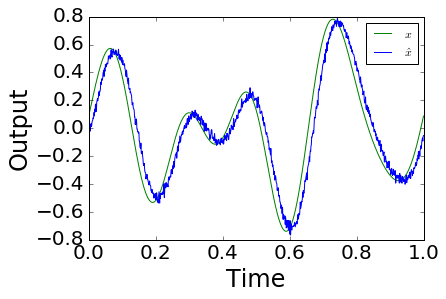

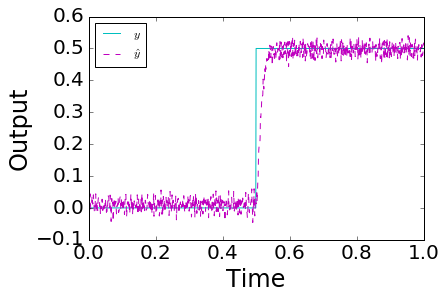

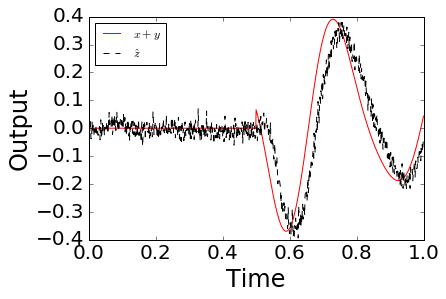

In [11]:
with model:
    stimB.output = lambda t: 0 if (t<.5) else .5
    
sim = nengo.Simulator(model)
sim.run(T, progress_bar=False)

figure()
plot(t, sim.data[stimA_p],'g', label="$x$")
plot(t, sim.data[ensA_p],'b', label="$\hat{x}$")
legend(loc='best')
ylabel("Output")
xlabel("Time")

figure()
plot(t, sim.data[stimB_p],'c', label="$y$")
plot(t, sim.data[ensB_p],'m--', label="$\hat{y}$")
legend(loc='best')
ylabel("Output")
xlabel("Time")

figure()
plot(t, sim.data[stimB_p]*sim.data[stimA_p],'r', label="$x+y$")
plot(t, sim.data[ensD_p],'k--', label="$\hat{z}$")
legend(loc='best')
ylabel("Output")
xlabel("Time");